In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Web Crawler

In [ ]:
# install chromium, its driver, and selenium
!apt update
!apt install chromium-chromedriver
!pip install selenium
# set options to be headless, ..
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 https://developer.download.nvidia.com/compute/c

In [ ]:
import time
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pathlib
from datetime import datetime
import pytz
from pytz import timezone
from selenium.webdriver.common.keys import Keys

def crawl_content(url, keywords) :
  driver = webdriver.Chrome('chromedriver',options=options)  
  driver.get(url)

  # Wait for initialize, in seconds
  wait = WebDriverWait(driver, 20)

  #search for keywords
  search = driver.find_element_by_xpath('//*[@id="header"]/div/nav/form/div/input')
  search.send_keys(keywords)
  search.send_keys(Keys.RETURN)  

  time.sleep(8)

  article_list = []
  nextPage = True  
  count = 0
  while nextPage:   
  # while nextPage and count < 3:
    time.sleep(8)
    all_news_link = driver.find_elements_by_css_selector("a.d-flex.article.listing.mb-3.pb-3")

    listOflinks=[]
    for el in all_news_link:
      link = el.get_property('href')
      listOflinks.append(link)

    all_field_category = driver.find_elements_by_css_selector('span.field-category') 
    
    listOfField = []
    for i in all_field_category:
      listOfField.append(i.text)

    time.sleep(8)

    #check the last news article crawled
    csv_file_checking = '/content/drive/Shared drives/NLP Assignment/checking_news.csv'
    file = pathlib.Path(csv_file)
    file2 = pathlib.Path(csv_file_checking)    
    valid = True
    condition = False
    i = 0
    while (i < len(listOflinks)) and valid:   
      driver.get(listOflinks[i])
      time.sleep(8)

      field_category = listOfField[i]

      reload = True
      while reload:
        try:
          time_created = driver.execute_script("return document.querySelector('div.article-meta > div:last-child').innerText.split('-').pop().trim();")
          time.sleep(5)
          time_created = datetime.strptime(time_created, '%B %d, %Y  @ %I:%M%p')
          reload = False
        except:
          reload = True

      timezone = pytz.timezone("Asia/Kuala_Lumpur")
      time_created = time_created.astimezone(timezone)
      time_created = time_created.strftime("%Y-%m-%d %H:%M:%S")

      #title
      title = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#main > div > div > div.col > div:nth-child(1) > div > h1 > span"))).text
      
      #author
      try : 
        author =  wait.until(EC.presence_of_element_located((By.XPATH,"//*[@id='main']/div/div/div[1]/div[1]/div/div/div[1]/div[1]/div/span/a"))).text
      
      except:
        author = " "
    
      #content
      content = wait.until(EC.presence_of_all_elements_located((By.TAG_NAME,"p")))

      all_content = []

      for j in content:
        all_content.append(j.text)
      
      if file2.exists():
        existed_news = pd.read_csv(csv_file_checking)

        record = existed_news[existed_news['Keyword'] == keywords]
        if len(record.index) != 0 :
          existed_date = record['Time Created'].iloc[0]
          existed_title = record['Title'].iloc[0]

          date_time = datetime.strptime(time_created, "%Y-%m-%d %H:%M:%S")
          exist_date = datetime.strptime(existed_date, "%Y-%m-%d %H:%M:%S")

          if (date_time >= exist_date) and (title not in existed_title):
            valid = True
            article_details = {'Keyword': keywords, 'Category': field_category, 'Time Created': time_created, 'Title' : title, 'Author' : author, 'Content' : all_content}
            article_list.append(article_details)

            if i == (len(listOflinks)-1):
              condition = True

            else:
              condition = False

          else:
            valid = False 
            condition = False
        
        else:
          article_details = {'Keyword': keywords, 'Category': field_category, 'Time Created': time_created, 'Title' : title, 'Author' : author, 'Content' : all_content}
          article_list.append(article_details)    
          condition = True

      else:
        article_details = {'Keyword': keywords, 'Category': field_category, 'Time Created': time_created, 'Title' : title, 'Author' : author, 'Content' : all_content}
        article_list.append(article_details)
        condition = True

      i += 1    

    if condition:
      driver.get(url)      

      #search for keywords
      search = driver.find_element_by_xpath('//*[@id="header"]/div/nav/form/div/input')
      search.send_keys(keywords)
      search.send_keys(Keys.RETURN)  
      time.sleep(8)
          
      count += 1
      a = 0 
      while a < count:
        try:
          #go to next page
          next_button = driver.find_element_by_css_selector("#main > div > div.row > div.col > nav > ul > li.page-item.ml-auto > a")
          next_button.click()
        except:
          break
        
        a += 1

    else:
      nextPage = False

  if article_list != []:
    results = pd.DataFrame(article_list)
    results["Time Created"] = pd.to_datetime(results["Time Created"], format="%Y-%m-%d %H:%M:%S")
    results = results.sort_values(by="Time Created")
  
    if file.exists ():
        results.to_csv(csv_file, mode = 'a', index=False, header = False)
    else:
        results.to_csv(csv_file, index=False)
            
    last_row = pd.DataFrame(results.tail(1))
    if file2.exists ():
      record = existed_news[existed_news['Keyword'] == keywords]
      if len(record) != 0:
        last_record_datetime = last_row['Time Created'].iloc[0]

        existed_news.loc[existed_news["Keyword"] == keywords, 'Time Created'] = last_record_datetime
        existed_news.loc[existed_news["Keyword"] == keywords, 'Title'] = last_row['Title'].iloc[0]
        existed_news.to_csv(csv_file_checking, index=False)

      else:
        last_row.to_csv(csv_file_checking, mode = 'a', index=False, header = False)

    else:
      last_row.to_csv(csv_file_checking, index=False)

csv_file = '/content/drive/Shared drives/NLP Assignment/news.csv' 
crawl_content('https://www.nst.com.my/','Covid-19')

final_results = pd.read_csv('/content/drive/Shared drives/NLP Assignment/news.csv')
final_results["Time Created"] = pd.to_datetime(final_results["Time Created"], format="%Y-%m-%d %H:%M:%S")
final_results = final_results.sort_values(by="Time Created")
final_results = final_results.drop_duplicates(subset ="Title",keep = False)
final_results.to_csv(csv_file, index=False)

###Import data

In [ ]:
#remove warning message
import warnings
warnings.filterwarnings("ignore")

# Required libraries
import pandas as pd
import numpy as np

#Read the dataFrame
news = pd.read_csv('/content/drive/Shared drives/NLP Assignment/news.csv')

In [ ]:
news

,Keyword,Category,Time Created,Title,Author,Content
0,AZ,FOOTBALL,2017-12-15 19:48:00,Cougars' double mission against PSG,Mohd Fitrie Muhamad,"['', '×', '', 'KUALA LUMPUR: The under-12, und..."
1,AZ,FOOTBALL,2017-12-16 19:10:00,AMD Malaysia Cougars moment of glory,Mohd Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: Academy Mokhtar Da..."
2,AZ,FOOTBALL,2017-12-17 20:44:00,AMD lose all three finals.,Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: AMD Malaysia Couga..."
3,AZ,NATION,2018-01-05 16:17:00,Flood victims get a royal visit,Isma Ismail,['CHUKAI: Some 900 flood victims at the Sekola...
4,AZ,NATION,2018-03-04 22:42:00,"Police announce transfers, promotions of 20 se...",Teoh Pei Ying,['KUALA LUMPUR: Police today announced transfe...
...,...,...,...,...,...,...
1269,Covid-19,FOOTBALL,2021-09-17 08:02:00,Tun Sharifah Rodziah Cup cancelled again,Farah Azharie,['The Tun Sharifah Rodziah Cup (TSRC) is the l...
1270,Covid-19,NATION,2021-09-17 09:00:00,Education firm switched gears to distribute Co...,Azdee Amir,['PETALING JAYA: The Covid-19 pandemic has for...
1271,Covid-19,NATION,2021-09-17 09:20:00,NUTP: Work harder to make reluctant students g...,Farah Solhi,['KUALA LUMPUR: The National Union of the Teac...
1272,Covid-19,NATION,2021-09-17 09:30:00,Expert: Dip in cases may be 'false trend',Veena Babulal,['KUALA LUMPUR: The rising Covid-19 positivity...


In [ ]:
news.shape

(1274, 6)

In [ ]:
news.dtypes

Keyword         object
Category        object
Time Created    object
Title           object
Author          object
Content         object
dtype: object

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Keyword       1274 non-null   object
 1   Category      1274 non-null   object
 2   Time Created  1274 non-null   object
 3   Title         1274 non-null   object
 4   Author        1250 non-null   object
 5   Content       1274 non-null   object
dtypes: object(6)
memory usage: 59.8+ KB


###Text Preprocessing

####Check missing value

In [ ]:
#check missing value
nullValue = news.isnull().any()
nullValue

Keyword         False
Category        False
Time Created    False
Title           False
Author           True
Content         False
dtype: bool

####Remove punctuation and convert to lower case

In [ ]:
def text_clean(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text= text.strip()
    
    return text

cleaned = lambda x: text_clean(x)

In [ ]:
import re, string

string.punctuation

news['Cleaned_Articles'] = news['Content'].apply(cleaned)
news.head(10)

,Keyword,Category,Time Created,Title,Author,Content,Cleaned_Articles
0,AZ,FOOTBALL,2017-12-15 19:48:00,Cougars' double mission against PSG,Mohd Fitrie Muhamad,"['', '×', '', 'KUALA LUMPUR: The under-12, und...",× kuala lumpur the under12 under13 and under1...
1,AZ,FOOTBALL,2017-12-16 19:10:00,AMD Malaysia Cougars moment of glory,Mohd Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: Academy Mokhtar Da...",× bukit jalil academy mokhtar dahari amd did ...
2,AZ,FOOTBALL,2017-12-17 20:44:00,AMD lose all three finals.,Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: AMD Malaysia Couga...",× bukit jalil amd malaysia cougars failed to ...
3,AZ,NATION,2018-01-05 16:17:00,Flood victims get a royal visit,Isma Ismail,['CHUKAI: Some 900 flood victims at the Sekola...,chukai some 900 flood victims at the sekolah k...
4,AZ,NATION,2018-03-04 22:42:00,"Police announce transfers, promotions of 20 se...",Teoh Pei Ying,['KUALA LUMPUR: Police today announced transfe...,kuala lumpur police today announced transfers ...
5,AZ,GROOVE,2018-03-17 10:42:00,"As an actress, versatility a must' [NSTTV]",Tahir Alhamzah,"['', '×', '', 'SANGEETA Krishnasamy says as an...",× sangeeta krishnasamy says as an actress she...
6,AZ,GROOVE,2018-03-21 13:40:00,#Showbiz: New mom Siti feels like she's dreaming,Tahir Alhamzah,"['', '×', '', 'KUALA LUMPUR: Despite being a m...",× kuala lumpur despite being a mother for rea...
7,AZ,GROOVE,2018-03-22 12:05:00,#Showbiz: Heart-warming pic of a grateful Siti...,Aref Omar,"['', '×', '', ""KUALA LUMPUR: Malaysia's top si...",× kuala lumpur malaysias top singer datuk ser...
8,AZ,GROOVE,2018-03-25 22:36:00,"#Showbiz: The wait is over, Siti Nurhaliza's b...",Aref Omar,"['', '×', '', 'KUALA LUMPUR: A week after givi...",× kuala lumpur a week after giving birth to h...
9,AZ,GROOVE,2018-03-26 12:53:00,#Showbiz: 'I lost lots of blood' – Siti Nurhal...,Aref Omar,"['', '×', '', 'KUALA LUMPUR: When it came to g...",× kuala lumpur when it came to giving birth a...


####Tokenization

In [ ]:
import nltk
from __future__ import division
import nltk, re
from nltk import word_tokenize
from nltk import regexp_tokenize
from nltk.tag import pos_tag
from nltk.draw import tree
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
def tokenization(text):
  words = word_tokenize(text) 
  return words

tokens = lambda x: tokenization(x)

In [ ]:
news['Cleaned_Articles'] = news['Cleaned_Articles'].apply(tokens)
news.head(10)

,Keyword,Category,Time Created,Title,Author,Content,Cleaned_Articles
0,AZ,FOOTBALL,2017-12-15 19:48:00,Cougars' double mission against PSG,Mohd Fitrie Muhamad,"['', '×', '', 'KUALA LUMPUR: The under-12, und...","[×, kuala, lumpur, the, under12, under13, and,..."
1,AZ,FOOTBALL,2017-12-16 19:10:00,AMD Malaysia Cougars moment of glory,Mohd Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: Academy Mokhtar Da...","[×, bukit, jalil, academy, mokhtar, dahari, am..."
2,AZ,FOOTBALL,2017-12-17 20:44:00,AMD lose all three finals.,Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: AMD Malaysia Couga...","[×, bukit, jalil, amd, malaysia, cougars, fail..."
3,AZ,NATION,2018-01-05 16:17:00,Flood victims get a royal visit,Isma Ismail,['CHUKAI: Some 900 flood victims at the Sekola...,"[chukai, some, 900, flood, victims, at, the, s..."
4,AZ,NATION,2018-03-04 22:42:00,"Police announce transfers, promotions of 20 se...",Teoh Pei Ying,['KUALA LUMPUR: Police today announced transfe...,"[kuala, lumpur, police, today, announced, tran..."
5,AZ,GROOVE,2018-03-17 10:42:00,"As an actress, versatility a must' [NSTTV]",Tahir Alhamzah,"['', '×', '', 'SANGEETA Krishnasamy says as an...","[×, sangeeta, krishnasamy, says, as, an, actre..."
6,AZ,GROOVE,2018-03-21 13:40:00,#Showbiz: New mom Siti feels like she's dreaming,Tahir Alhamzah,"['', '×', '', 'KUALA LUMPUR: Despite being a m...","[×, kuala, lumpur, despite, being, a, mother, ..."
7,AZ,GROOVE,2018-03-22 12:05:00,#Showbiz: Heart-warming pic of a grateful Siti...,Aref Omar,"['', '×', '', ""KUALA LUMPUR: Malaysia's top si...","[×, kuala, lumpur, malaysias, top, singer, dat..."
8,AZ,GROOVE,2018-03-25 22:36:00,"#Showbiz: The wait is over, Siti Nurhaliza's b...",Aref Omar,"['', '×', '', 'KUALA LUMPUR: A week after givi...","[×, kuala, lumpur, a, week, after, giving, bir..."
9,AZ,GROOVE,2018-03-26 12:53:00,#Showbiz: 'I lost lots of blood' – Siti Nurhal...,Aref Omar,"['', '×', '', 'KUALA LUMPUR: When it came to g...","[×, kuala, lumpur, when, it, came, to, giving,..."


####Pos tagging

In [ ]:
# import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

def pos_tagger(nltk_tag):
  adj = 0
  verb = 0
  adverb = 0
  noun = 0
  if nltk_tag.startswith('J'):
    adj += 1
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    verb += 1
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    noun += 1
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    adverb += 1
    return wordnet.ADV
  else:          
    return None

def pos_tagging(text):
  tagged = nltk.pos_tag(text)
  wordnet_tagged_list = list(map(lambda x: (x[0], pos_tagger(x[1])), tagged))
  return wordnet_tagged_list

postagged = lambda x: pos_tagging(x)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
news['Cleaned_Articles'] = news['Cleaned_Articles'].apply(postagged)
news.head(10)

,Keyword,Category,Time Created,Title,Author,Content,Cleaned_Articles
0,AZ,FOOTBALL,2017-12-15 19:48:00,Cougars' double mission against PSG,Mohd Fitrie Muhamad,"['', '×', '', 'KUALA LUMPUR: The under-12, und...","[(×, a), (kuala, n), (lumpur, v), (the, None),..."
1,AZ,FOOTBALL,2017-12-16 19:10:00,AMD Malaysia Cougars moment of glory,Mohd Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: Academy Mokhtar Da...","[(×, a), (bukit, n), (jalil, n), (academy, n),..."
2,AZ,FOOTBALL,2017-12-17 20:44:00,AMD lose all three finals.,Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: AMD Malaysia Couga...","[(×, a), (bukit, n), (jalil, n), (amd, n), (ma..."
3,AZ,NATION,2018-01-05 16:17:00,Flood victims get a royal visit,Isma Ismail,['CHUKAI: Some 900 flood victims at the Sekola...,"[(chukai, v), (some, None), (900, None), (floo..."
4,AZ,NATION,2018-03-04 22:42:00,"Police announce transfers, promotions of 20 se...",Teoh Pei Ying,['KUALA LUMPUR: Police today announced transfe...,"[(kuala, n), (lumpur, n), (police, n), (today,..."
5,AZ,GROOVE,2018-03-17 10:42:00,"As an actress, versatility a must' [NSTTV]",Tahir Alhamzah,"['', '×', '', 'SANGEETA Krishnasamy says as an...","[(×, a), (sangeeta, n), (krishnasamy, n), (say..."
6,AZ,GROOVE,2018-03-21 13:40:00,#Showbiz: New mom Siti feels like she's dreaming,Tahir Alhamzah,"['', '×', '', 'KUALA LUMPUR: Despite being a m...","[(×, a), (kuala, n), (lumpur, v), (despite, No..."
7,AZ,GROOVE,2018-03-22 12:05:00,#Showbiz: Heart-warming pic of a grateful Siti...,Aref Omar,"['', '×', '', ""KUALA LUMPUR: Malaysia's top si...","[(×, a), (kuala, n), (lumpur, n), (malaysias, ..."
8,AZ,GROOVE,2018-03-25 22:36:00,"#Showbiz: The wait is over, Siti Nurhaliza's b...",Aref Omar,"['', '×', '', 'KUALA LUMPUR: A week after givi...","[(×, a), (kuala, n), (lumpur, v), (a, None), (..."
9,AZ,GROOVE,2018-03-26 12:53:00,#Showbiz: 'I lost lots of blood' – Siti Nurhal...,Aref Omar,"['', '×', '', 'KUALA LUMPUR: When it came to g...","[(×, a), (kuala, n), (lumpur, n), (when, None)..."


####Lemmatization

In [ ]:
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer

def lemmatization(text):
  lemmatizer = WordNetLemmatizer()

  lemmatized_sentence = []
  for word,tag in text:    
    if tag != None:
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

  return lemmatized_sentence

lemmatized = lambda x: lemmatization(x)
news['Cleaned_Articles'] = news['Cleaned_Articles'].apply(lemmatized)
news.head(10)

,Keyword,Category,Time Created,Title,Author,Content,Cleaned_Articles
0,AZ,FOOTBALL,2017-12-15 19:48:00,Cougars' double mission against PSG,Mohd Fitrie Muhamad,"['', '×', '', 'KUALA LUMPUR: The under-12, und...","[×, kuala, lumpur, under12, under13, under14, ..."
1,AZ,FOOTBALL,2017-12-16 19:10:00,AMD Malaysia Cougars moment of glory,Mohd Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: Academy Mokhtar Da...","[×, bukit, jalil, academy, mokhtar, dahari, am..."
2,AZ,FOOTBALL,2017-12-17 20:44:00,AMD lose all three finals.,Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: AMD Malaysia Couga...","[×, bukit, jalil, amd, malaysia, cougar, fail,..."
3,AZ,NATION,2018-01-05 16:17:00,Flood victims get a royal visit,Isma Ismail,['CHUKAI: Some 900 flood victims at the Sekola...,"[chukai, flood, victim, sekolah, kebangsaan, s..."
4,AZ,NATION,2018-03-04 22:42:00,"Police announce transfers, promotions of 20 se...",Teoh Pei Ying,['KUALA LUMPUR: Police today announced transfe...,"[kuala, lumpur, police, today, announce, trans..."
5,AZ,GROOVE,2018-03-17 10:42:00,"As an actress, versatility a must' [NSTTV]",Tahir Alhamzah,"['', '×', '', 'SANGEETA Krishnasamy says as an...","[×, sangeeta, krishnasamy, say, actress, be, u..."
6,AZ,GROOVE,2018-03-21 13:40:00,#Showbiz: New mom Siti feels like she's dreaming,Tahir Alhamzah,"['', '×', '', 'KUALA LUMPUR: Despite being a m...","[×, kuala, lumpur, be, mother, real, now, coun..."
7,AZ,GROOVE,2018-03-22 12:05:00,#Showbiz: Heart-warming pic of a grateful Siti...,Aref Omar,"['', '×', '', ""KUALA LUMPUR: Malaysia's top si...","[×, kuala, lumpur, top, singer, datuk, seri, s..."
8,AZ,GROOVE,2018-03-25 22:36:00,"#Showbiz: The wait is over, Siti Nurhaliza's b...",Aref Omar,"['', '×', '', 'KUALA LUMPUR: A week after givi...","[×, kuala, lumpur, week, give, birth, first, c..."
9,AZ,GROOVE,2018-03-26 12:53:00,#Showbiz: 'I lost lots of blood' – Siti Nurhal...,Aref Omar,"['', '×', '', 'KUALA LUMPUR: When it came to g...","[×, kuala, lumpur, come, give, birth, become, ..."


####Stopwords removal

In [ ]:
from nltk.corpus import stopwords
!pip install NRCLex
from nrclex import NRCLex

def remove_stopwords(text):
  cleaned_tokens = []
  stop_words = stopwords.words('english')

  if len(text) > 0 and text not in stop_words:
      cleaned_tokens = text

  return cleaned_tokens

stopwords_removed = lambda x: remove_stopwords(x)

     |████████████████████████████████| 396 kB 5.3 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=86daf1b92d21e4284c2d1843f6e6471cdcac980dd13f1614300cd2c6a56a49b4
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [ ]:
news['Cleaned_Articles'] = news['Cleaned_Articles'].apply(stopwords_removed)
news.head(10)

,Keyword,Category,Time Created,Title,Author,Content,Cleaned_Articles
0,AZ,FOOTBALL,2017-12-15 19:48:00,Cougars' double mission against PSG,Mohd Fitrie Muhamad,"['', '×', '', 'KUALA LUMPUR: The under-12, und...","[×, kuala, lumpur, under12, under13, under14, ..."
1,AZ,FOOTBALL,2017-12-16 19:10:00,AMD Malaysia Cougars moment of glory,Mohd Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: Academy Mokhtar Da...","[×, bukit, jalil, academy, mokhtar, dahari, am..."
2,AZ,FOOTBALL,2017-12-17 20:44:00,AMD lose all three finals.,Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: AMD Malaysia Couga...","[×, bukit, jalil, amd, malaysia, cougar, fail,..."
3,AZ,NATION,2018-01-05 16:17:00,Flood victims get a royal visit,Isma Ismail,['CHUKAI: Some 900 flood victims at the Sekola...,"[chukai, flood, victim, sekolah, kebangsaan, s..."
4,AZ,NATION,2018-03-04 22:42:00,"Police announce transfers, promotions of 20 se...",Teoh Pei Ying,['KUALA LUMPUR: Police today announced transfe...,"[kuala, lumpur, police, today, announce, trans..."
5,AZ,GROOVE,2018-03-17 10:42:00,"As an actress, versatility a must' [NSTTV]",Tahir Alhamzah,"['', '×', '', 'SANGEETA Krishnasamy says as an...","[×, sangeeta, krishnasamy, say, actress, be, u..."
6,AZ,GROOVE,2018-03-21 13:40:00,#Showbiz: New mom Siti feels like she's dreaming,Tahir Alhamzah,"['', '×', '', 'KUALA LUMPUR: Despite being a m...","[×, kuala, lumpur, be, mother, real, now, coun..."
7,AZ,GROOVE,2018-03-22 12:05:00,#Showbiz: Heart-warming pic of a grateful Siti...,Aref Omar,"['', '×', '', ""KUALA LUMPUR: Malaysia's top si...","[×, kuala, lumpur, top, singer, datuk, seri, s..."
8,AZ,GROOVE,2018-03-25 22:36:00,"#Showbiz: The wait is over, Siti Nurhaliza's b...",Aref Omar,"['', '×', '', 'KUALA LUMPUR: A week after givi...","[×, kuala, lumpur, week, give, birth, first, c..."
9,AZ,GROOVE,2018-03-26 12:53:00,#Showbiz: 'I lost lots of blood' – Siti Nurhal...,Aref Omar,"['', '×', '', 'KUALA LUMPUR: When it came to g...","[×, kuala, lumpur, come, give, birth, become, ..."


###Sentiment Analysis

In [ ]:
cleaned_data = news['Cleaned_Articles']
analyse_list = []

for i in cleaned_data: 
  str_list = ' '.join(i)
  analyse_list.append(str_list) 

In [ ]:
print(analyse_list)

['× kuala lumpur under12 under13 under14 team akademi mokhtar dahari amd malaysia cougars progress today knockout stage supermokh cup cougar under12 team emerge group b winner thrash qatarbased aspire academy cougar under13 under14 team emerge runnersup respective group cougar under12 team play japan kashima antler semifinal cougar under13 under14 team play paris saint germain psg side cougars under14 coach ahmad nurfaizal abdullah say be satisfy boy performance final group match today saw beat gyeongnam fc cougar be defend champion under14 category i be satisfy performance show want victory say nurfaizal psg be big name i be confident player do not fear fact be determine upset result under12 group amd malaysia panther ff south australia sport p kashima antler group b amd malaysia cougars aspire academy hnk hadjuk split jj football academy under13 group psg buriram unite amd malaysia panther urawa red diamond group b amd malaysia cougars az alkmaar gyeongnam fc ff south group amd malay

In [ ]:
from textblob import TextBlob

result = []
def textBlob_polarity(sentence):
  blob = TextBlob(sentence)
  analyse = blob.sentiment.polarity
  if analyse > 0:
    sentiment = 'Positive'
  else:
    sentiment = 'Negative'
  return sentiment

for i in analyse_list:
  result.append(textBlob_polarity(i))

In [ ]:
print(result)

['Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Po

In [ ]:
news['Cleaned_Sentence'] = analyse_list
news['Sentiment'] = result
news.head(10)

,Keyword,Category,Time Created,Title,Author,Content,Cleaned_Articles,Cleaned_Sentence,Sentiment
0,AZ,FOOTBALL,2017-12-15 19:48:00,Cougars' double mission against PSG,Mohd Fitrie Muhamad,"['', '×', '', 'KUALA LUMPUR: The under-12, und...","[×, kuala, lumpur, under12, under13, under14, ...",× kuala lumpur under12 under13 under14 team ak...,Positive
1,AZ,FOOTBALL,2017-12-16 19:10:00,AMD Malaysia Cougars moment of glory,Mohd Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: Academy Mokhtar Da...","[×, bukit, jalil, academy, mokhtar, dahari, am...",× bukit jalil academy mokhtar dahari amd do ma...,Positive
2,AZ,FOOTBALL,2017-12-17 20:44:00,AMD lose all three finals.,Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: AMD Malaysia Couga...","[×, bukit, jalil, amd, malaysia, cougar, fail,...",× bukit jalil amd malaysia cougar fail land ti...,Positive
3,AZ,NATION,2018-01-05 16:17:00,Flood victims get a royal visit,Isma Ismail,['CHUKAI: Some 900 flood victims at the Sekola...,"[chukai, flood, victim, sekolah, kebangsaan, s...",chukai flood victim sekolah kebangsaan sk buki...,Positive
4,AZ,NATION,2018-03-04 22:42:00,"Police announce transfers, promotions of 20 se...",Teoh Pei Ying,['KUALA LUMPUR: Police today announced transfe...,"[kuala, lumpur, police, today, announce, trans...",kuala lumpur police today announce transfer pr...,Negative
5,AZ,GROOVE,2018-03-17 10:42:00,"As an actress, versatility a must' [NSTTV]",Tahir Alhamzah,"['', '×', '', 'SANGEETA Krishnasamy says as an...","[×, sangeeta, krishnasamy, say, actress, be, u...",× sangeeta krishnasamy say actress be uncomfor...,Positive
6,AZ,GROOVE,2018-03-21 13:40:00,#Showbiz: New mom Siti feels like she's dreaming,Tahir Alhamzah,"['', '×', '', 'KUALA LUMPUR: Despite being a m...","[×, kuala, lumpur, be, mother, real, now, coun...",× kuala lumpur be mother real now country sing...,Positive
7,AZ,GROOVE,2018-03-22 12:05:00,#Showbiz: Heart-warming pic of a grateful Siti...,Aref Omar,"['', '×', '', ""KUALA LUMPUR: Malaysia's top si...","[×, kuala, lumpur, top, singer, datuk, seri, s...",× kuala lumpur top singer datuk seri siti nurh...,Positive
8,AZ,GROOVE,2018-03-25 22:36:00,"#Showbiz: The wait is over, Siti Nurhaliza's b...",Aref Omar,"['', '×', '', 'KUALA LUMPUR: A week after givi...","[×, kuala, lumpur, week, give, birth, first, c...",× kuala lumpur week give birth first child mal...,Positive
9,AZ,GROOVE,2018-03-26 12:53:00,#Showbiz: 'I lost lots of blood' – Siti Nurhal...,Aref Omar,"['', '×', '', 'KUALA LUMPUR: When it came to g...","[×, kuala, lumpur, come, give, birth, become, ...",× kuala lumpur come give birth become mother s...,Positive


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
news["Sentiment"] = encoder.fit_transform(news["Sentiment"])

news.head(10)

,Keyword,Category,Time Created,Title,Author,Content,Cleaned_Articles,Cleaned_Sentence,Sentiment
0,AZ,FOOTBALL,2017-12-15 19:48:00,Cougars' double mission against PSG,Mohd Fitrie Muhamad,"['', '×', '', 'KUALA LUMPUR: The under-12, und...","[×, kuala, lumpur, under12, under13, under14, ...",× kuala lumpur under12 under13 under14 team ak...,1
1,AZ,FOOTBALL,2017-12-16 19:10:00,AMD Malaysia Cougars moment of glory,Mohd Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: Academy Mokhtar Da...","[×, bukit, jalil, academy, mokhtar, dahari, am...",× bukit jalil academy mokhtar dahari amd do ma...,1
2,AZ,FOOTBALL,2017-12-17 20:44:00,AMD lose all three finals.,Fitrie Muhamad,"['', '×', '', 'BUKIT JALIL: AMD Malaysia Couga...","[×, bukit, jalil, amd, malaysia, cougar, fail,...",× bukit jalil amd malaysia cougar fail land ti...,1
3,AZ,NATION,2018-01-05 16:17:00,Flood victims get a royal visit,Isma Ismail,['CHUKAI: Some 900 flood victims at the Sekola...,"[chukai, flood, victim, sekolah, kebangsaan, s...",chukai flood victim sekolah kebangsaan sk buki...,1
4,AZ,NATION,2018-03-04 22:42:00,"Police announce transfers, promotions of 20 se...",Teoh Pei Ying,['KUALA LUMPUR: Police today announced transfe...,"[kuala, lumpur, police, today, announce, trans...",kuala lumpur police today announce transfer pr...,0
5,AZ,GROOVE,2018-03-17 10:42:00,"As an actress, versatility a must' [NSTTV]",Tahir Alhamzah,"['', '×', '', 'SANGEETA Krishnasamy says as an...","[×, sangeeta, krishnasamy, say, actress, be, u...",× sangeeta krishnasamy say actress be uncomfor...,1
6,AZ,GROOVE,2018-03-21 13:40:00,#Showbiz: New mom Siti feels like she's dreaming,Tahir Alhamzah,"['', '×', '', 'KUALA LUMPUR: Despite being a m...","[×, kuala, lumpur, be, mother, real, now, coun...",× kuala lumpur be mother real now country sing...,1
7,AZ,GROOVE,2018-03-22 12:05:00,#Showbiz: Heart-warming pic of a grateful Siti...,Aref Omar,"['', '×', '', ""KUALA LUMPUR: Malaysia's top si...","[×, kuala, lumpur, top, singer, datuk, seri, s...",× kuala lumpur top singer datuk seri siti nurh...,1
8,AZ,GROOVE,2018-03-25 22:36:00,"#Showbiz: The wait is over, Siti Nurhaliza's b...",Aref Omar,"['', '×', '', 'KUALA LUMPUR: A week after givi...","[×, kuala, lumpur, week, give, birth, first, c...",× kuala lumpur week give birth first child mal...,1
9,AZ,GROOVE,2018-03-26 12:53:00,#Showbiz: 'I lost lots of blood' – Siti Nurhal...,Aref Omar,"['', '×', '', 'KUALA LUMPUR: When it came to g...","[×, kuala, lumpur, come, give, birth, become, ...",× kuala lumpur come give birth become mother s...,1


In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Keyword           1274 non-null   object
 1   Category          1274 non-null   object
 2   Time Created      1274 non-null   object
 3   Title             1274 non-null   object
 4   Author            1250 non-null   object
 5   Content           1274 non-null   object
 6   Cleaned_Articles  1274 non-null   object
 7   Cleaned_Sentence  1274 non-null   object
 8   Sentiment         1274 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 89.7+ KB


###Data visualization

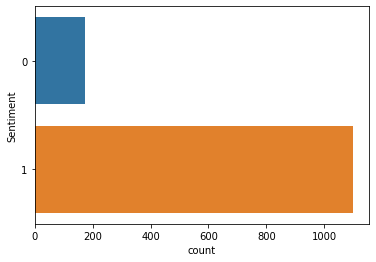

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#display the chart 
sns.countplot(y="Sentiment", data=news)
plt.show()

In [ ]:
negative_news = news[news['Sentiment'] == 0]
negative_news = negative_news['Cleaned_Sentence']
positive_news = news[news['Sentiment'] == 1]
positive_news = positive_news['Cleaned_Sentence']

In [ ]:

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(str(data))
    
    wordcloud = WordCloud(background_color=color,
                          width=2500,
                          height=2500
                          ).generate(str(data))
    plt.figure(1,figsize=(50, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive words


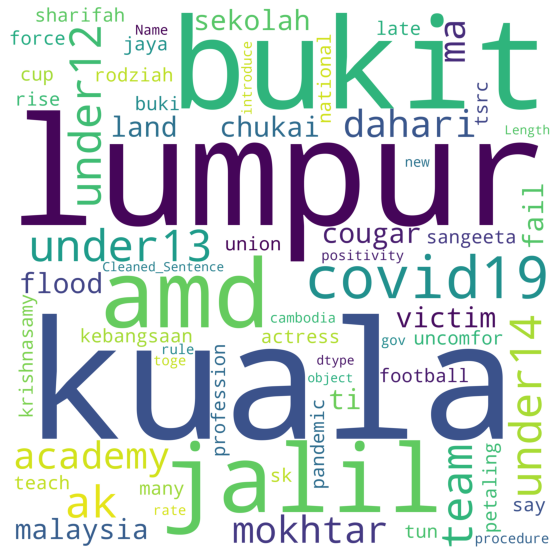

Negative words


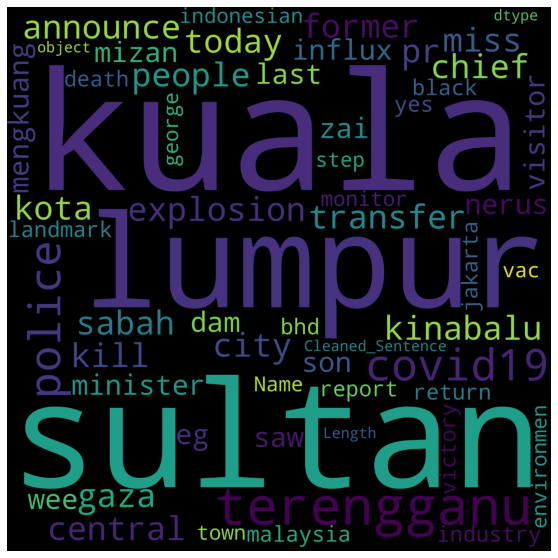

In [ ]:
from wordcloud import WordCloud
print("Positive words")
wordcloud_draw(positive_news,'white')
print("Negative words")
wordcloud_draw(negative_news)
# print("Neutral words")
# wordcloud_draw(neutral_news)

###Train Test Split

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

bag_of_words = count_vectorizer.fit_transform(news['Cleaned_Sentence'])
feature_names = count_vectorizer.get_feature_names()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

,100,10day,10th,13th,14day,14th,15th,17th,18millionstrong,1960s,1980s,1990s,200th,2020,2021,20th,20yearold,21st,21yearold,23percent,24th,268bed,26yearold,27,27th,28th,28yearold,29year,30day,30yearold,32yearold,33yearold,35th,37yearold,39year,40th,40yearold,49yearold,4yearold,50th,...,zii,zijian,zika,zimbabwe,zin,zinc,zionist,zivkovic,zizan,zlatan,zohor,zone,zoo,zoom,zoong,zoonotic,zouma,zu,zubai,zubair,zubi,zuha,zuhri,zuki,zul,zulaika,zulkaedah,zulkaferi,zulkarnain,zulkeffeli,zulkefley,zulkifle,zulkifli,zulkiflie,zulkiflies,zuraida,zuriani,zuriatcare,zya,ﬂexible
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(count_vectorizer.vocabulary_)

{'kuala': 10197, 'lumpur': 10921, 'under12': 20130, 'under13': 20131, 'under14': 20132, 'team': 19096, 'akademi': 549, 'mokhtar': 11976, 'dahari': 4417, 'amd': 756, 'malaysia': 11120, 'cougars': 4093, 'progress': 14764, 'today': 19574, 'knockout': 10105, 'stage': 18241, 'supermokh': 18709, 'cup': 4336, 'cougar': 4092, 'emerge': 5733, 'group': 7580, 'winner': 21196, 'thrash': 19408, 'qatarbased': 15031, 'aspire': 1255, 'academy': 146, 'runnersup': 16561, 'respective': 15806, 'play': 14226, 'japan': 9442, 'kashima': 9792, 'antler': 983, 'semifinal': 17221, 'paris': 13644, 'saint': 16688, 'germain': 7265, 'psg': 14890, 'side': 17616, 'coach': 3466, 'ahmad': 487, 'nurfaizal': 12993, 'abdullah': 81, 'say': 16885, 'be': 1846, 'satisfy': 16849, 'boy': 2368, 'performance': 13929, 'final': 6597, 'match': 11348, 'saw': 16877, 'beat': 1858, 'gyeongnam': 7659, 'fc': 6460, 'defend': 4644, 'champion': 3076, 'category': 2918, 'show': 17562, 'want': 20911, 'victory': 20711, 'big': 2086, 'name': 12427,

In [ ]:
from sklearn.model_selection import train_test_split

X = bag_of_words
y = np.array(news.iloc[:, news.columns == 'Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)

print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

X_train:  (1019, 21657)
y_train:  (1019, 1)
X_test:  (255, 21657)
y_test:  (255, 1)


###Smote
As our dataset is imbalance, so we need to use SMOTE to handle the imbalance dataset before modelling it.

In [ ]:
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

print("Number of occurences X_train dataset: ", X_train.shape)
print("Number of occurences y_train dataset: ", y_train.shape)
print("Number of occurences X_test dataset: ", X_test.shape)
print("Number of occurences y_test dataset: ", y_test.shape)

Shape of X: (1274, 21657)
Shape of y: (1274, 1)
Number of occurences X_train dataset:  (1019, 21657)
Number of occurences y_train dataset:  (1019, 1)
Number of occurences X_test dataset:  (255, 21657)
Number of occurences y_test dataset:  (255, 1)


In [ ]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))

sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

#confirm the data has been balanced
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))

Before OverSampling, counts of label '0': [138]
Before OverSampling, counts of label '1': [881]
After OverSampling, the shape of train_X: (1762, 21657)
After OverSampling, the shape of train_y: (1762,) 

After OverSampling, counts of label '0': 881
After OverSampling, counts of label '1': 881


###Machine Learning Algorithms

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

####Naive Bayes Classifier

In [ ]:
#import NB
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

#train using the algorithm
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

            Testset                    
Accuracy:   0.8705882352941177
Recall:     0.9360730593607306
Precision:  0.9151785714285714
F1 score:   0.9255079006772009


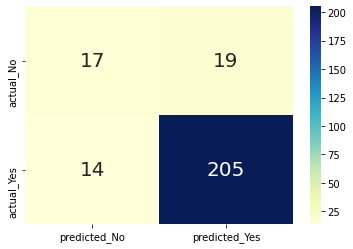

In [ ]:
#use trainset to do prediction on testset
pred_nb = nb.predict(X_test)

#display confusion matrix for testset
nb_cm=confusion_matrix(y_test,pred_nb)
sns.heatmap(nb_cm,xticklabels=['predicted_No', 'predicted_Yes'], yticklabels=['actual_No','actual_Yes'],
           annot=True, fmt='d', annot_kws={'fontsize':20},cmap="YlGnBu");
#print the accuracy score, recall, precision and F1 score 
print("            Testset                    ")
print("Accuracy:  ",accuracy_score(y_test,pred_nb))
print("Recall:    ",recall_score(y_test,pred_nb))
print("Precision: ",precision_score(y_test,pred_nb))
print("F1 score:  ",f1_score(y_test,pred_nb))

####KNN

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
%matplotlib inline

#K-Nearest Neighbour algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)

#train using the algorithm
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

            Testset
Accuracy:   0.3137254901960784
Recall:     0.2146118721461187
Precision:  0.94
F1 score:   0.3494423791821561


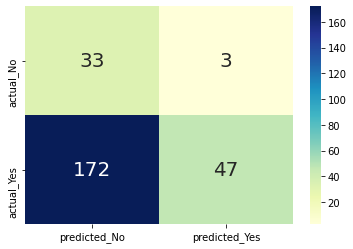

In [ ]:
#use trainset to do prediction on testset
pred_knn = knn.predict(X_test)

#display confusion matrix for testset
KNN_cm=confusion_matrix(y_test,pred_knn)
sns.heatmap(KNN_cm,xticklabels=['predicted_No', 'predicted_Yes'], yticklabels=['actual_No','actual_Yes'],
           annot=True, fmt='d', annot_kws={'fontsize':20},cmap="YlGnBu");

#print the accuracy score, recall, precision and F1 score 
print("            Testset")
print("Accuracy:  ",accuracy_score(y_test,pred_knn))
print("Recall:    ", recall_score(y_test,pred_knn))
print("Precision: ", precision_score(y_test,pred_knn))
print("F1 score:  ",f1_score(y_test,pred_knn))

####Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#predict
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

            Testset
Accuracy:   0.8666666666666667
Recall:     0.9771689497716894
Precision:  0.8806584362139918
F1 score:   0.9264069264069263


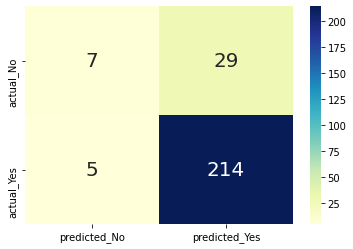

In [ ]:
#display confusion matrix for testset
rf_cm=confusion_matrix(y_test,rf_pred)
sns.heatmap(rf_cm,xticklabels=['predicted_No', 'predicted_Yes'], yticklabels=['actual_No','actual_Yes'],
           annot=True, fmt='d', annot_kws={'fontsize':20},cmap="YlGnBu");


#print the accuracy score, recall, precision and F1 score 
print("            Testset")
print("Accuracy:  ",accuracy_score(y_test,rf_pred))
print("Recall:    ",recall_score(y_test,rf_pred))
print("Precision: ",precision_score(y_test,rf_pred))
print("F1 score:  ",f1_score(y_test,rf_pred))

####SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

svm_pred = clf.predict(X_test)

            Testset
Accuracy:   0.8627450980392157
Recall:     0.9726027397260274
Precision:  0.8801652892561983
F1 score:   0.9240780911062906


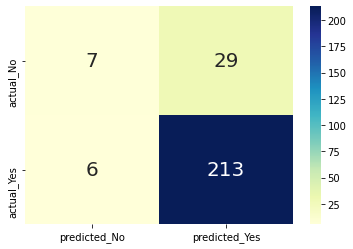

In [ ]:
#display confusion matrix for testset
svm_cm=confusion_matrix(y_test,svm_pred)
sns.heatmap(svm_cm,xticklabels=['predicted_No', 'predicted_Yes'], yticklabels=['actual_No','actual_Yes'],
           annot=True, fmt='d', annot_kws={'fontsize':20},cmap="YlGnBu");


#print the accuracy score, recall, precision and F1 score 
print("            Testset")
print("Accuracy:  ",accuracy_score(y_test,svm_pred))
print("Recall:    ",recall_score(y_test,svm_pred))
print("Precision: ",precision_score(y_test,svm_pred))
print("F1 score:  ",f1_score(y_test,svm_pred))

####Logistic Regression

In [ ]:
#import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
from sklearn.pipeline import make_pipeline

#train using the algorithm
logreg = LogisticRegression()

#train using the algorithm
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

            Testset
Accuracy:   0.8862745098039215
Recall:     0.9634703196347032
Precision:  0.9094827586206896
F1 score:   0.9356984478935699


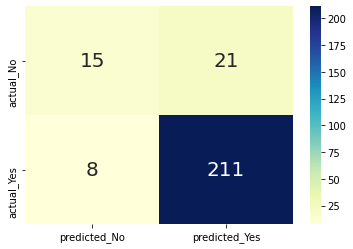

In [ ]:
#prediction on testset
logreg_pred = logreg.predict(X_test)

#display confusion matrix for testset 
log_cm_test = confusion_matrix(y_test,logreg_pred)
sns.heatmap(log_cm_test,xticklabels=['predicted_No', 'predicted_Yes'], yticklabels=['actual_No','actual_Yes'],
           annot=True, fmt='d', annot_kws={'fontsize':20},cmap="YlGnBu");

#print the accuracy score, recall, precision and F1 score 
print("            Testset")
print("Accuracy:  ",accuracy_score(y_test,logreg_pred))
print("Recall:    ",recall_score(y_test,logreg_pred))
print("Precision: ",precision_score(y_test,logreg_pred))
print("F1 score:  ",f1_score(y_test,logreg_pred))

####Decision Tree

In [ ]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier 

#train using the algorithm
dctree = DecisionTreeClassifier()

#train using the algorithm
dctree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

            Testset
Accuracy:   0.8156862745098039
Recall:     0.8767123287671232
Precision:  0.9056603773584906
F1 score:   0.8909512761020882


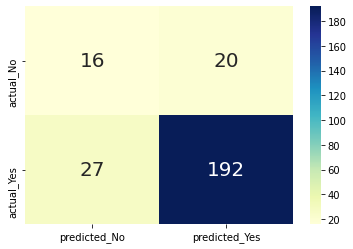

In [ ]:
#use trainset to do prediction on testset
dctree_pred = dctree.predict(X_test)

#display confusion matrix for testset 
dctree_cm_test = confusion_matrix(y_test,dctree_pred)
sns.heatmap(dctree_cm_test,xticklabels=['predicted_No', 'predicted_Yes'], yticklabels=['actual_No','actual_Yes'],
           annot=True, fmt='d', annot_kws={'fontsize':20},cmap="YlGnBu");

#print the accuracy score, recall, precision and F1 score 
print("            Testset")
print("Accuracy:  ",accuracy_score(y_test,dctree_pred))
print("Recall:    ",recall_score(y_test,dctree_pred))
print("Precision: ",precision_score(y_test,dctree_pred))
print("F1 score:  ",f1_score(y_test,dctree_pred))

####XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

            Testset
Accuracy:   0.8666666666666667
Recall:     0.9771689497716894
Precision:  0.8806584362139918
F1 score:   0.9264069264069263


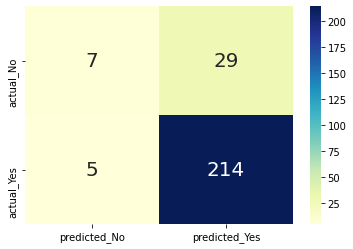

In [ ]:
#Make prediction for test data
xgb_pred = xgb.predict(X_test)

#display confusion matrix for testset 
xgb_cm_test = confusion_matrix(y_test,xgb_pred)
sns.heatmap(xgb_cm_test,xticklabels=['predicted_No', 'predicted_Yes'], yticklabels=['actual_No','actual_Yes'],
           annot=True, fmt='d', annot_kws={'fontsize':20},cmap="YlGnBu");

#print the accuracy score, recall, precision and F1 score 
print("            Testset")
print("Accuracy:  ",accuracy_score(y_test,xgb_pred))
print("Recall:    ",recall_score(y_test,xgb_pred))
print("Precision: ",precision_score(y_test,xgb_pred))
print("F1 score:  ",f1_score(y_test,xgb_pred))

###Evaluation

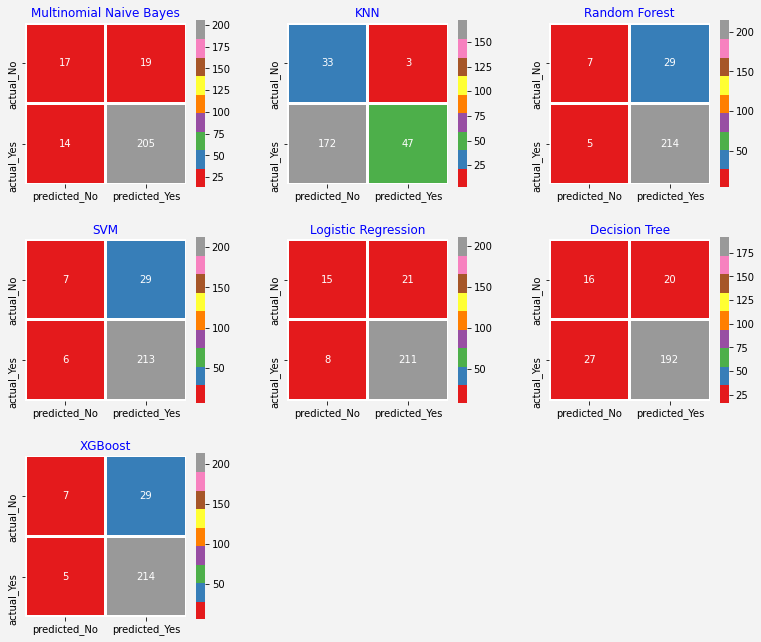

In [ ]:
import itertools
import matplotlib.pyplot as plt

evaluation_lst = [nb, knn, rf, clf, logreg, dctree, xgb]

evaluation_length = len(evaluation_lst)

evaluation_label = ['Multinomial Naive Bayes','KNN', 'Random Forest', 'SVM', 'Logistic Regression', 'Decision Tree', 'XGBoost']

eva_fig = plt.figure(figsize=(13,15))
eva_fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(evaluation_lst,range(evaluation_length),evaluation_label):
    plt.subplot(4,3,j+1)
    eva_predictions = i.predict(X_test)
    conf_matrix = confusion_matrix(y_test,eva_predictions)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=['predicted_No', 'predicted_Yes'],
                yticklabels=['actual_No','actual_Yes'],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)


In [ ]:
#gives model report in dataframe
def model_report(testing_y,pred,name) :
    accuracy     = accuracy_score(testing_y,pred)
    recallscore  = recall_score(testing_y,pred)
    precision    = precision_score(testing_y,pred)
    f1score      = f1_score(testing_y,pred) 
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                      })
    return df

#outputs for every model
model_nb = model_report(y_test,pred_nb,"Naive Bayes")
model_knn = model_report(y_test,pred_knn,"KNN")
model_rf = model_report(y_test,rf_pred,"Random Forest")
model_svm = model_report(y_test,svm_pred,"SVM")
model_logreg = model_report(y_test, logreg_pred,"Logistic Regression")
model_dctree = model_report(y_test, dctree_pred,"Decision Tree")
model_xgb = model_report(y_test, xgb_pred,"XGBoost")

model_performances = pd.concat([model_nb, model_knn, model_rf, model_svm, model_logreg, model_dctree, model_xgb],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)
model_performances

,Model,Accuracy_score,Recall_score,Precision,f1_score
0,Naive Bayes,0.870588,0.936073,0.915179,0.925508
1,KNN,0.313725,0.214612,0.940000,0.349442
2,Random Forest,0.866667,0.977169,0.880658,0.926407
3,SVM,0.862745,0.972603,0.880165,0.924078
4,Logistic Regression,0.886275,0.963470,0.909483,0.935698
5,Decision Tree,0.815686,0.876712,0.905660,0.890951
6,XGBoost,0.866667,0.977169,0.880658,0.926407


In [ ]:
import plotly.graph_objs as go
import plotly.offline as py  

model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width = 0.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model Performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Metrics",
                                     zerolinewidth = 1,
                                     ticklen = 5, 
                                     gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,
                                     ticklen=5,
                                     gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )

trace1  = output_tracer("Accuracy_score", "#6699FF")
trace2  = output_tracer('Recall_score', "red")
trace3  = output_tracer('Precision', "#33CC99")
trace4  = output_tracer('f1_score', "lightgrey")

data = [trace1, trace2, trace3, trace4]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve,classification_report, f1_score, average_precision_score)
#Naive Baiyes
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, pred_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, th_nb = precision_recall_curve(y_test, pred_nb)
#KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
precision_knn, recall_knn, th_knn = precision_recall_curve(y_test, pred_knn)
#Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
precision_rf, recall_rf, th_rf = precision_recall_curve(y_test, rf_pred)
#SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_pred)
roc_auc_svm = auc(fpr_svm, tpr_svm)
precision_svm, recall_svm, th_svm = precision_recall_curve(y_test, svm_pred)
# Logistic regression
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_pred)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
precision_logreg, recall_logreg, th_logreg = precision_recall_curve(y_test, logreg_pred)
#Decision Tree
fpr_Tree, tpr_Tree, thresholds_Tree = roc_curve(y_test, dctree_pred)
roc_auc_Tree = auc(fpr_Tree, tpr_Tree)
precision_Tree, recall_Tree, th_Tree = precision_recall_curve(y_test, dctree_pred)
#XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_pred)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
precision_xgb, recall_xgb, th_xgb = precision_recall_curve(y_test, xgb_pred)

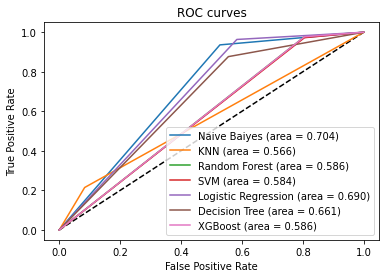

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#Naive Baiyes
plt.plot(fpr_nb, tpr_nb, label='Naive Baiyes (area = %0.3f)' % roc_auc_nb)
# KNN
plt.plot(fpr_knn, tpr_knn, label='KNN (area = %0.3f)' % roc_auc_knn)
#Random Forest
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.3f)' % roc_auc_rf) 
#SVM
plt.plot(fpr_svm, tpr_svm, label='SVM (area = %0.3f)' % roc_auc_svm) 
#Logistic regression
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression (area = %0.3f)' % roc_auc_logreg) 
#Decision Tree
plt.plot(fpr_Tree, tpr_Tree, label='Decision Tree (area = %0.3f)' % roc_auc_Tree)
#XGBoost
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.3f)' % roc_auc_xgb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='best')
plt.show()


###Testing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
print('Test for positive and negative')
print('Enter comment to be analysed: ', end=" ")
test = []
test.append(input())
test_dtm = count_vectorizer.transform(test)
predLabel = nb.predict(test_dtm)
tags = ['Negative', 'Positive']

# Display Output
print('The review is predicted',tags[predLabel[0]])

Test for positive and negative
Enter comment to be analysed:  I am happy
The review is predicted Positive


###Ensemble learning model



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection

#Defining Ensemble Learning Model
# combine all the models used
estimators = []

model1 = MultinomialNB()
estimators.append(('naive bayes', model1))

model2 = KNeighborsClassifier(n_neighbors = 3)
estimators.append(('knn', model2))

model3 = RandomForestClassifier(n_estimators=200, random_state=0)
estimators.append(('random forest', model3))

model4 = SVC()
estimators.append(('svm', model4))

model5 = LogisticRegression()
estimators.append(('logistic regression', model5))

model6 = DecisionTreeClassifier(max_depth = 3)
estimators.append(('decision tree', model6))

model7 = XGBClassifier()
estimators.append(('xgb', model7))

            Testset                    
Accuracy:   0.8745098039215686
Recall:     0.8745098039215686
Precision:  0.8545048399106477
F1 score:   0.8560715514275885


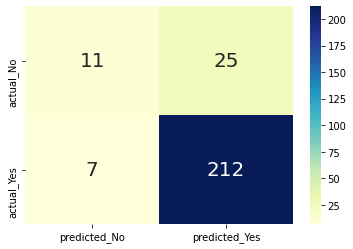

In [ ]:
#In hard voting, the predicted output class is a class with the highest majority of votes
ensemble = VotingClassifier(estimators = estimators, voting ='hard')

#train using the algorithm
ensemble.fit(X_train, y_train)

#use trainset to do prediction on testset
ensemble_pred = ensemble.predict(X_test)

#display confusion matrix for testset
ensemble_cm=confusion_matrix(y_test,ensemble_pred)
sns.heatmap(ensemble_cm,xticklabels=['predicted_No', 'predicted_Yes'], yticklabels=['actual_No','actual_Yes'],
           annot=True, fmt='d', annot_kws={'fontsize':20},cmap="YlGnBu");
           
#print the accuracy score, recall, precision and F1 score 
print("            Testset                    ")
print("Accuracy:  ",accuracy_score(y_test,ensemble_pred))
print("Recall:    ",recall_score(y_test,ensemble_pred, average='weighted'))
print("Precision: ",precision_score(y_test,ensemble_pred, average='weighted'))
print("F1 score:  ",f1_score(y_test,ensemble_pred, average='weighted'))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
print('Test for positive and negative')
print('Enter comment to be analysed: ', end=" ")
test = []
test.append(input())
test_dtm = count_vectorizer.transform(test)
predLabel = ensemble.predict(test_dtm)
tags = ['Negative', 'Positive']

# Display Output
print('The review is predicted',tags[predLabel[0]])

Test for positive and negative
Enter comment to be analysed:  i am happy
The review is predicted Negative
